# Build and train MicNet


In [23]:
%run MicNet_model.py

In [18]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

import skimage
import skimage.io
import tifffile

import time
import torch
import torch.hub
import torch.nn

from MicNet_model import *

## 1) Load data

(25233, 27452, 3)


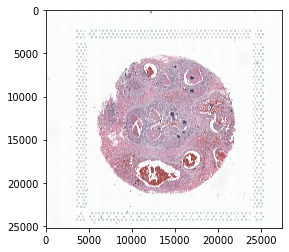

In [2]:
### Read counts
count_stat = pd.read_csv("./run/1_count_stat_breast_cancer_FFPE.csv", index_col=0)
count = pd.read_csv("./run/1_pd_count_norm_breast_cancer_FFPE.csv", index_col=0)
image_file = "./dataset/Visium_FFPE_Human_Breast_Cancer_image.tif"
image = tifffile.imread(os.path.join(image_file))
print(image.shape)
image_norm = image.copy()
plt.imshow(image_norm)
plt.show()

In [3]:
# Read position meta file
transformation_file =  "./dataset/Spot_metadata.csv"
pd_meta = pd.read_table(transformation_file, index_col=0, sep=",")
pd_meta

,Row,Col,X,Y,Spot_radius
0,,,,,
GTAGACAACCGATGAA-1,7,55,5406,13126,94
ACAGATTAGGTTAGTG-1,7,57,5407,13417,94
TGGTATCGGTCTGTAT-1,7,59,5407,13707,94
ATTATCTCGACAGATC-1,7,61,5407,13997,94
TGAGATCAAATACTCA-1,7,63,5407,14287,94
...,...,...,...,...,...
GCCCTGAGGATGGGCT-1,68,74,20805,15869,94
CGGGCGATGGATCACG-1,69,75,21057,16013,94
TGCGGACTTGACTCCG-1,68,76,20805,16159,94


In [4]:
# Split training and testing
np.random.seed(82321)
indexes_all = pd_meta.index.values
training_indexes = np.random.choice(indexes_all, int(len(indexes_all) * 0.8), replace=False)
testing_indexes = [_ for _ in indexes_all if _ not in training_indexes]
print("#Training: {}, #Testing: {}".format(len(training_indexes), len(testing_indexes)))
training_indexes.sort()
testing_indexes.sort()

#Training: 2014, #Testing: 504


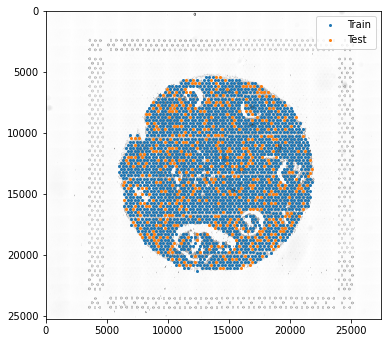

In [5]:
# Plot training & testing distribution
plt.figure(figsize=(6, 6))
plt.imshow(image_norm[..., 0], cmap="gray")
coords_x = pd_meta.loc[training_indexes, "Y"].values
coords_y = pd_meta.loc[training_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Train")
coords_x = pd_meta.loc[testing_indexes, "Y"].values
coords_y = pd_meta.loc[testing_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Test")
plt.gca().set_aspect('equal')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.legend()
plt.show()

## 2) Check data loader

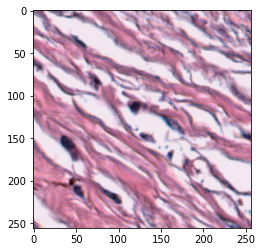

tensor([1327])


In [6]:
# Generator
np.random.seed()
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)
for x, y in train_loader:
    plt.imshow(normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True))
    plt.show()
    print(y)
    break

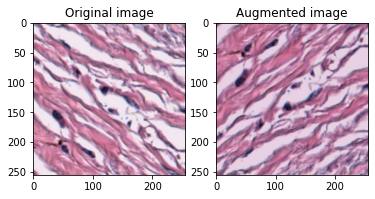

In [7]:
image = normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True)
plt.subplot(121)
plt.imshow(image)
plt.title("Original image")
plt.subplot(122)
plt.imshow(normalize(augmentor(normalize(image)), inverse=True))
plt.title("Augmented image")
plt.show()

## 3) Create network

In [10]:
from torch.nn.modules import MSELoss
from utils_eval import NCESoftmaxLoss, NCECriterion
from MicNet_model import MicNet, NCEAverage


device = torch.device("cuda:1")
image_shape = 256
n_genes = count_stat.shape[1]
n_data = len(training_indexes)
n_out_features = 100
imagenet = 'resnet101'

# NCE parameters
# Increasing nce_m improves stability
# !!! Adding batch normalization layer improves stability 
nce_k = 100
nce_t = 0.07
nce_m = 0.9
softmax = False

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.01   # ori 0.01
momentum = 0.9
weight_decay = 0.0001
gradient_clip = 5

# Generator
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=1)
test_set = Dataset(testing_indexes, image_norm, count, pd_meta, augmentation=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False, num_workers=1)

# Set model
model = MicNet(image_shape=image_shape, n_genes=n_genes, n_out_features=n_out_features, 
               imagenet=imagenet, genenet=[500, 100]).to(device)
contrast = NCEAverage(n_out_features, n_data, nce_k, nce_t, nce_m, softmax, device=device).to(device)
criterion_image = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)
criterion_gene = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

Using cache found in /home2/s223242/.cache/torch/hub/pytorch_vision_v0.4.0


In [11]:
model_dir = "./models/2_MicNet_breast_cancer_FFPE"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [12]:
model

MicNet(
  (imagenet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
"""TO LOAD:"""
model_file = None
if model_file is not None:
    print("=> loading checkpoint '{}'".format(model_file))
    checkpoint = torch.load(model_file, map_location=device)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    contrast.load_state_dict(checkpoint['contrast'])
    del checkpoint

## 4) Train

Epoch: [0][10/101]	loss 29.667 (31.136)	image_p 0.003 (0.011)	gene_p 0.022 (0.017)
Epoch: [0][20/101]	loss 26.997 (29.572)	image_p 0.066 (0.015)	gene_p 0.029 (0.015)
Epoch: [0][30/101]	loss 27.355 (28.858)	image_p 0.004 (0.015)	gene_p 0.013 (0.015)
Epoch: [0][40/101]	loss 24.745 (28.015)	image_p 0.004 (0.020)	gene_p 0.041 (0.015)
Epoch: [0][50/101]	loss 25.227 (27.306)	image_p 0.007 (0.020)	gene_p 0.005 (0.016)
Epoch: [0][60/101]	loss 23.153 (26.605)	image_p 0.030 (0.021)	gene_p 0.000 (0.017)
Epoch: [0][70/101]	loss 19.881 (25.906)	image_p 0.027 (0.024)	gene_p 0.027 (0.019)
Epoch: [0][80/101]	loss 18.393 (25.077)	image_p 0.078 (0.031)	gene_p 0.097 (0.022)
Epoch: [0][90/101]	loss 16.571 (24.224)	image_p 0.154 (0.041)	gene_p 0.037 (0.025)
Epoch: [0][100/101]	loss 9.239 (23.114)	image_p 0.440 (0.065)	gene_p 0.357 (0.042)


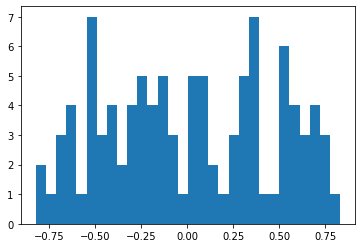

Val epoch 0, average corr 0.01184713476175504
New best corr_val: 0.0118 at epoch 0, model saved.
Epoch: [1][10/101]	loss 28.964 (30.230)	image_p 0.004 (0.022)	gene_p 0.045 (0.021)
Epoch: [1][20/101]	loss 24.599 (28.179)	image_p 0.013 (0.021)	gene_p 0.021 (0.024)
Epoch: [1][30/101]	loss 25.082 (26.962)	image_p 0.011 (0.025)	gene_p 0.003 (0.026)
Epoch: [1][40/101]	loss 23.812 (26.265)	image_p 0.046 (0.027)	gene_p 0.024 (0.025)
Epoch: [1][50/101]	loss 23.355 (25.705)	image_p 0.046 (0.030)	gene_p 0.012 (0.023)
Epoch: [1][60/101]	loss 20.999 (25.043)	image_p 0.059 (0.034)	gene_p 0.057 (0.024)
Epoch: [1][70/101]	loss 22.726 (24.507)	image_p 0.067 (0.036)	gene_p 0.014 (0.026)
Epoch: [1][80/101]	loss 19.040 (23.921)	image_p 0.072 (0.040)	gene_p 0.122 (0.028)
Epoch: [1][90/101]	loss 18.470 (23.277)	image_p 0.141 (0.048)	gene_p 0.009 (0.032)
Epoch: [1][100/101]	loss 12.952 (22.403)	image_p 0.426 (0.072)	gene_p 0.202 (0.044)
Val epoch 1, average corr 0.20586441887967005
New best corr_val: 0.2059 

Epoch: [9][100/101]	loss 11.849 (21.251)	image_p 0.661 (0.140)	gene_p 0.219 (0.049)
Val epoch 9, average corr 0.4428925346962532
New best corr_val: 0.4429 at epoch 9, model saved.
Saving model checkpoint...
Epoch: [10][10/101]	loss 24.672 (24.036)	image_p 0.045 (0.064)	gene_p 0.006 (0.053)
Epoch: [10][20/101]	loss 22.110 (23.910)	image_p 0.068 (0.057)	gene_p 0.051 (0.051)
Epoch: [10][30/101]	loss 19.604 (23.097)	image_p 0.179 (0.069)	gene_p 0.069 (0.055)
Epoch: [10][40/101]	loss 22.420 (22.638)	image_p 0.066 (0.073)	gene_p 0.059 (0.059)
Epoch: [10][50/101]	loss 17.723 (22.249)	image_p 0.199 (0.079)	gene_p 0.045 (0.065)
Epoch: [10][60/101]	loss 19.706 (21.770)	image_p 0.077 (0.084)	gene_p 0.095 (0.069)
Epoch: [10][70/101]	loss 17.003 (21.282)	image_p 0.177 (0.097)	gene_p 0.130 (0.075)
Epoch: [10][80/101]	loss 13.727 (20.669)	image_p 0.254 (0.109)	gene_p 0.246 (0.086)
Epoch: [10][90/101]	loss 10.635 (19.955)	image_p 0.457 (0.127)	gene_p 0.279 (0.098)
Epoch: [10][100/101]	loss 7.791 (19.0

Epoch: [18][70/101]	loss 13.513 (17.264)	image_p 0.150 (0.167)	gene_p 0.232 (0.142)
Epoch: [18][80/101]	loss 11.351 (16.695)	image_p 0.314 (0.184)	gene_p 0.273 (0.153)
Epoch: [18][90/101]	loss 9.115 (16.044)	image_p 0.615 (0.209)	gene_p 0.232 (0.172)
Epoch: [18][100/101]	loss 5.633 (15.188)	image_p 0.798 (0.251)	gene_p 0.581 (0.200)
Val epoch 18, average corr 0.5860431076904908
Saving model checkpoint...
Epoch: [19][10/101]	loss 18.251 (18.588)	image_p 0.086 (0.106)	gene_p 0.103 (0.137)
Epoch: [19][20/101]	loss 15.672 (18.076)	image_p 0.166 (0.130)	gene_p 0.214 (0.127)
Epoch: [19][30/101]	loss 14.139 (17.503)	image_p 0.271 (0.141)	gene_p 0.173 (0.130)
Epoch: [19][40/101]	loss 15.643 (17.085)	image_p 0.139 (0.152)	gene_p 0.233 (0.139)
Epoch: [19][50/101]	loss 14.635 (16.715)	image_p 0.208 (0.164)	gene_p 0.131 (0.142)
Epoch: [19][60/101]	loss 15.341 (16.441)	image_p 0.212 (0.172)	gene_p 0.193 (0.147)
Epoch: [19][70/101]	loss 13.898 (15.943)	image_p 0.279 (0.192)	gene_p 0.149 (0.157)
Epoc

Epoch: [27][60/101]	loss 14.929 (15.409)	image_p 0.199 (0.220)	gene_p 0.132 (0.168)
Epoch: [27][70/101]	loss 11.509 (15.030)	image_p 0.264 (0.237)	gene_p 0.216 (0.171)
Epoch: [27][80/101]	loss 13.045 (14.535)	image_p 0.493 (0.265)	gene_p 0.224 (0.179)
Epoch: [27][90/101]	loss 10.208 (14.168)	image_p 0.536 (0.291)	gene_p 0.256 (0.183)
Epoch: [27][100/101]	loss 7.182 (13.677)	image_p 0.869 (0.330)	gene_p 0.430 (0.191)
Val epoch 27, average corr 0.6355217826920246
New best corr_val: 0.6355 at epoch 27, model saved.
Saving model checkpoint...
Epoch: [28][10/101]	loss 14.296 (16.356)	image_p 0.193 (0.215)	gene_p 0.201 (0.159)
Epoch: [28][20/101]	loss 14.659 (15.465)	image_p 0.221 (0.232)	gene_p 0.169 (0.171)
Epoch: [28][30/101]	loss 14.080 (15.405)	image_p 0.354 (0.235)	gene_p 0.124 (0.171)
Epoch: [28][40/101]	loss 16.269 (15.277)	image_p 0.171 (0.241)	gene_p 0.148 (0.162)
Epoch: [28][50/101]	loss 16.758 (15.083)	image_p 0.275 (0.249)	gene_p 0.203 (0.168)
Epoch: [28][60/101]	loss 13.078 (14

Epoch: [36][40/101]	loss 9.936 (12.358)	image_p 0.508 (0.316)	gene_p 0.409 (0.246)
Epoch: [36][50/101]	loss 11.381 (12.274)	image_p 0.283 (0.317)	gene_p 0.237 (0.252)
Epoch: [36][60/101]	loss 12.273 (12.091)	image_p 0.224 (0.323)	gene_p 0.258 (0.261)
Epoch: [36][70/101]	loss 7.049 (11.660)	image_p 0.539 (0.343)	gene_p 0.565 (0.276)
Epoch: [36][80/101]	loss 7.358 (11.186)	image_p 0.645 (0.374)	gene_p 0.498 (0.293)
Epoch: [36][90/101]	loss 5.186 (10.798)	image_p 0.770 (0.403)	gene_p 0.549 (0.305)
Epoch: [36][100/101]	loss 4.115 (10.296)	image_p 0.888 (0.444)	gene_p 0.633 (0.324)
Val epoch 36, average corr 0.6817753649309856
Saving model checkpoint...
Epoch: [37][10/101]	loss 15.422 (12.625)	image_p 0.182 (0.295)	gene_p 0.194 (0.229)
Epoch: [37][20/101]	loss 11.155 (12.431)	image_p 0.356 (0.298)	gene_p 0.280 (0.245)
Epoch: [37][30/101]	loss 9.842 (11.883)	image_p 0.302 (0.317)	gene_p 0.440 (0.268)
Epoch: [37][40/101]	loss 10.686 (11.759)	image_p 0.377 (0.333)	gene_p 0.294 (0.269)
Epoch: [

Epoch: [45][40/101]	loss 10.422 (10.517)	image_p 0.326 (0.377)	gene_p 0.339 (0.341)
Epoch: [45][50/101]	loss 9.037 (10.252)	image_p 0.428 (0.391)	gene_p 0.425 (0.354)
Epoch: [45][60/101]	loss 9.411 (10.048)	image_p 0.422 (0.399)	gene_p 0.425 (0.364)
Epoch: [45][70/101]	loss 6.756 (9.736)	image_p 0.540 (0.416)	gene_p 0.623 (0.378)
Epoch: [45][80/101]	loss 7.544 (9.405)	image_p 0.483 (0.431)	gene_p 0.443 (0.399)
Epoch: [45][90/101]	loss 4.962 (9.145)	image_p 0.846 (0.446)	gene_p 0.630 (0.414)
Epoch: [45][100/101]	loss 3.232 (8.868)	image_p 0.811 (0.463)	gene_p 0.842 (0.437)
Val epoch 45, average corr 0.6974782094795678
Saving model checkpoint...
Epoch: [46][10/101]	loss 14.175 (12.056)	image_p 0.343 (0.320)	gene_p 0.161 (0.266)
Epoch: [46][20/101]	loss 12.299 (10.916)	image_p 0.366 (0.373)	gene_p 0.308 (0.318)
Epoch: [46][30/101]	loss 9.525 (10.873)	image_p 0.482 (0.377)	gene_p 0.329 (0.319)
Epoch: [46][40/101]	loss 8.862 (10.719)	image_p 0.446 (0.374)	gene_p 0.423 (0.330)
Epoch: [46][50

In [24]:
hist = dict()
hist['loss'] = []
hist['corr_val'] = []
hist['image_loss'] = []
hist['image_prob'] = []
hist['gene_loss'] = []
hist['gene_prob'] = []
hist_best = dict()
best_corr = -float("inf")  

save_freq = 1
for epoch in range(51):
    loss, image_loss, image_prob, gene_loss, gene_prob = \
        train(epoch, train_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
              gradient_clip=gradient_clip, print_freq=10, device=device)
    hist['loss'].append(loss)
    hist['image_loss'].append(image_loss)
    hist['image_prob'].append(image_prob)
    hist['gene_loss'].append(gene_loss)
    hist['gene_prob'].append(gene_prob)
    
    corr = test(epoch, test_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
              gradient_clip=gradient_clip, print_freq=10, device=device)
    hist['corr_val'].append(corr)

    # Check if this is the best corr so far
    if corr > best_corr:
        best_corr = corr
        hist_best = {
            'model': model.state_dict(),
            'contrast': contrast.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'corr_val': corr
        }
        torch.save(hist_best, os.path.join(model_dir, "epoch_best_breast.pt"))
        print(f"New best corr_val: {best_corr:.4f} at epoch {epoch}, model saved.")

    # Regular save by frequency
    if epoch % save_freq == 0 and epoch != 0:
        print("Saving model checkpoint...")
        state = { 'model': model.state_dict(),
                  'contrast': contrast.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': epoch }
        torch.save(state, os.path.join(model_dir, f"epoch_{epoch}.pt"))

# Save full history at the end
torch.save(hist, os.path.join(model_dir, "hist.pt"))


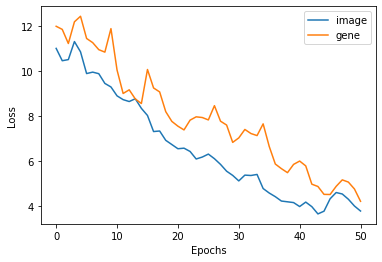

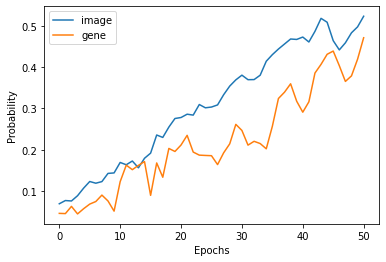

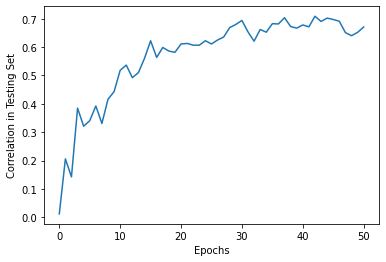

In [25]:
plt.plot(np.arange(len(hist['image_loss'])), hist['image_loss'])
plt.plot(np.arange(len(hist['gene_loss'])), hist['gene_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["image", "gene"])
plt.show()
plt.plot(np.arange(len(hist['image_prob'])), hist['image_prob'])
plt.plot(np.arange(len(hist['gene_prob'])), hist['gene_prob'])
plt.xlabel("Epochs")
plt.ylabel("Probability")
plt.legend(["image", "gene"])
plt.show()
plt.plot(hist['corr_val'])
plt.xlabel("Epochs")
plt.ylabel("Correlation in Testing Set")
plt.show()

In [26]:
np.argmax(hist['corr_val'])

42